In [1]:
import os
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt 
from itertools import chain
import numpy as np
import pickle
import sklearn
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
import gtfparse
from gtfparse import read_gtf

#### TODO change ####
#LGG: lower grade glioma, KICH: Kidney Chromophobe
disease = 'LGG' 
path = Path('transcript_data')
tcga_path = Path(path/disease)
#####################

if not (tcga_path/'plots').exists():
    !mkdir $tcga_path/'plots'

### Translate transcript expression to exon expression and filter

read transcript expression from file
694116 exon expressions were calculated from 197044 transcripts.
Exon and miRNA counts have 517 common patient ids.
filter out genes without AS (with variance < 0.05)
  Number genes before: 49922 Number exons before: 694116
  Number genes after: 20426 Number exons after: 618470
filter out exons with variance <= 0.3 between samples
  Number exons before: 618470
  Number exons after: 569741


exon_id,ENSE00000327880.1,ENSE00000329326.2,ENSE00000330966.5,ENSE00000331191.1,ENSE00000331592.1,ENSE00000331689.2,ENSE00000331693.2,ENSE00000331695.2,ENSE00000332771.1,ENSE00000333665.1,...,ENSE00003783926.1,ENSE00003783927.1,ENSE00003783928.1,ENSE00003783935.1,ENSE00003783936.1,ENSE00003783938.1,ENSE00003783942.1,ENSE00003783943.1,ENSE00003783944.1,ENSE00003783946.1
case_id,,,,,,,,,,,,,,,,,,,,,
TCGA-CS-4938-01,2.839692,1.585576,-3.2849,-1.055255,-1.9064,-9.965847,-9.965847,-9.965847,2.5736,-7.6558,...,-9.9658,0.4799,-9.9658,-9.9658,-3.7426,-9.9658,-1.8623,-9.9658,-2.0916,6.299336
TCGA-CS-4941-01,4.042129,2.112342,-9.9658,1.653200,-1.2283,-7.051806,-7.051806,-7.051806,4.4196,-3.6397,...,-7.3969,3.9882,-9.9658,-9.9658,-2.0995,-6.9865,-0.0142,-4.4423,-9.9658,5.301105
TCGA-CS-4942-01,2.807996,1.522414,-2.3726,0.847319,-2.7231,-6.266104,-6.266104,-6.266104,4.4140,-5.7361,...,-9.9658,2.4565,-9.9658,-9.9658,-3.3574,-9.9658,-1.2464,-9.9658,-3.9899,4.494116
TCGA-CS-4943-01,2.176113,-0.577315,-3.5269,4.040560,-1.5138,-7.330708,-7.330708,-7.330708,3.1419,-9.9658,...,-9.9658,-0.2293,-9.9658,-9.9658,-1.7107,-9.9658,-9.9658,-3.7426,-9.9658,4.477773
TCGA-CS-4944-01,2.051488,-1.784586,-0.8018,-3.919001,-3.9110,-5.552702,-5.552702,-5.552702,2.5083,-7.2520,...,-9.9658,-5.4554,-9.9658,-9.9658,-3.3721,-9.9658,-2.5952,-9.9658,-4.6028,6.585285


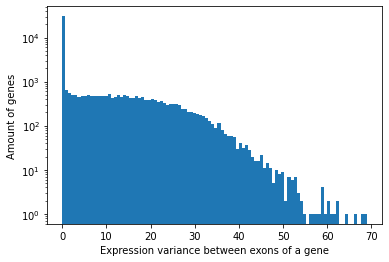

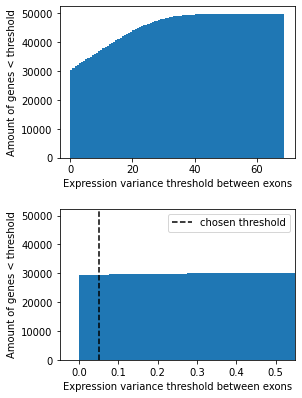

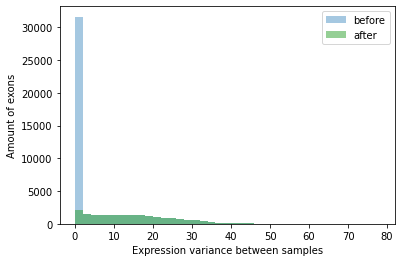

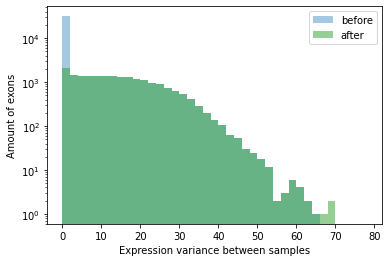

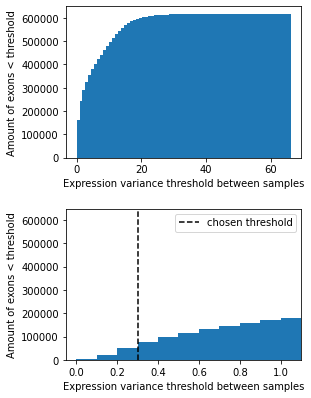

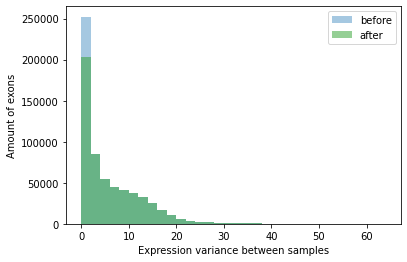

In [2]:
#mapping TCGA samples to sample type and cancer type
def get_mapping_sample_to_cancer(path):
    if not Path(path/'unaligned.tsv').is_file():
        !wget https://github.com/jvivian/ipython_notebooks/raw/master/tcga_rnaseq_analysis/unaligned.tsv
        !mv unaligned.tsv $path/unaligned.tsv
    sample_map = pd.read_csv(path/'unaligned.tsv', sep='\t')
    return sample_map

def filter_expression_by_disease(transcript_counts, disease, sample_map):
    print(f'filter out samples from other diseases than {disease}\n  Number samples before: {len(transcript_counts.columns)}')
    sample_map = sample_map[sample_map.disease == disease]
    sample_map['sample'] = sample_map['barcode'].str[0:15]
    disease_samples = list(set(sample_map['sample']))
    disease_samples = [sample for sample in disease_samples if sample in transcript_counts.columns]
    disease_samples.append('sample')
    transcript_counts = transcript_counts[disease_samples]
    print(f'  Number samples after: {len(transcript_counts.columns)}')
    return transcript_counts, sample_map

#https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables/sample-type-codes
#filter out Additional - New Primary (5), Metastatic (6), Additional Metastatic (7), EBV Immortalized Normal (13), sample type 15 (15), sample type 16 (16), Cell Lines (50), Primary Xenograft Tissue (60), Cell Line Derived Xenograft Tissue (61), sample type 99 (99)
def filter_expression_by_sampletype(transcript_counts, sample_map):
    print(f'filter out samples with a wrong sample_type\n  Number samples before: {len(transcript_counts.columns)}')
    sample_map['keep_sample'] = sample_map.sample_type_name.apply(lambda x: x not in [5, 6, 7, 13, 15, 16, 50, 60, 61, 99])
    sample_map = sample_map[sample_map['keep_sample']].drop('keep_sample',axis=1)
    sample_map['sample'] = sample_map['barcode'].str[0:15]
    sampletype_samples = list(set(sample_map['sample']))
    sampletype_samples = [smpl for smpl in sampletype_samples if smpl in transcript_counts.columns]
    sample_map['in'] = sample_map.apply(lambda x: x['sample'] in sampletype_samples,axis=1)
    sample_map = sample_map[sample_map['in']]
    fig1, ax1 = plt.subplots(figsize=(6,4))
    sample_map.sample_type.value_counts().plot(kind='bar',ax=ax1)
    plt.xlabel("Sample types")
    plt.ylabel("Amount of samples")
    plt.savefig(tcga_path/'plots'/'sample_types.png', bbox_inches = "tight",dpi=200)
    sampletype_samples.append('sample')
    transcript_counts = transcript_counts[sampletype_samples]
    print(f'  Number samples after: {len(transcript_counts.columns)}')
    return transcript_counts, sample_map

#get TCGA hg38 transcript expression data from XENA
def get_expression_data(tcga_path, path, disease):
    file = tcga_path/(disease+'_transcript_counts.parquet')
    if not file.is_file():
        if not tcga_path.exists():
            !mkdir $tcga_path
        if not Path(path/'tcga_Kallisto_tpm').is_file():
            print(f'Download transcript expression data from TCGA')
            !wget 'https://toil.xenahubs.net/download/tcga_Kallisto_tpm.gz'
            !gunzip tcga_Kallisto_tpm.gz
            !mv tcga_Kallisto_tpm $path/tcga_Kallisto_tpm
        transcript_counts = pd.read_csv(path/'tcga_Kallisto_tpm', sep='\t')
        sample_map = get_mapping_sample_to_cancer(path)
        transcript_counts, sample_map = filter_expression_by_disease(transcript_counts, disease, sample_map)
        transcript_counts, sample_map = filter_expression_by_sampletype(transcript_counts, sample_map)
        transcript_counts.to_parquet(file)
    else:
        print('read transcript expression from file')
        transcript_counts = pd.read_parquet(file)
    return transcript_counts 

#transcript reference genome
def get_transcript_map(path):
    file = path/'transcript_map.parquet'
    if not file.is_file():
        if not Path(path/"gencode.v23.chr_patch_hapl_scaff.annotation.gtf").is_file():
            !wget ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_23/gencode.v23.chr_patch_hapl_scaff.annotation.gtf.gz
            !gunzip 'gencode.v23.chr_patch_hapl_scaff.annotation.gtf.gz'
            !mv 'gencode.v23.chr_patch_hapl_scaff.annotation.gtf' $path/'gencode.v23.chr_patch_hapl_scaff.annotation.gtf'
        !pip install gtfparse
        transcript_map = read_gtf(path/"gencode.v23.chr_patch_hapl_scaff.annotation.gtf")
        transcript_map = transcript_map[transcript_map.feature == 'exon']
        transcript_map.to_parquet(file)
    else: 
        transcript_map = pd.read_parquet(file)
    transcript_map = transcript_map[['transcript_id','exon_id','gene_id']]
    return transcript_map

def transcript_to_exon_expression(transcript_counts, transcript_map):
    samples = list(transcript_counts.columns)
    samples.remove('sample')
    transcript_counts[samples] = 2**transcript_counts[samples] - 0.001
    exon_counts = transcript_counts.merge(transcript_map, left_on = 'sample', right_on = 'transcript_id', how='left') #copies expression per exon
    exon_counts_2 = exon_counts.groupby('exon_id').agg('sum')
    exon_counts_2[samples] = np.log2(exon_counts_2[samples] + 0.001)
    exon_counts_2[['transcript_id','gene_id']] = exon_counts[['exon_id','transcript_id','gene_id']].groupby('exon_id').agg({'transcript_id': lambda x : list(set(x)), 'gene_id' : 'first'})
    print(f'{len(exon_counts_2)} exon expressions were calculated from {len(transcript_counts)} transcripts.')
    exon_counts_2['exon_id'] = exon_counts_2.index
    return exon_counts_2

#alternative splicing filter, all exon counts same -> no AS in this gene -> filter gene
def filter_no_AS_genes(exon_counts,used_caseids,threshold=0.05):
    exon_counts['median_count'] = exon_counts[used_caseids].median(axis=1)
    exon_counts['var'] = exon_counts['median_count'].copy() #take median across samples
    gene_level = exon_counts[['gene_id','median_count','var']].groupby('gene_id', as_index=False).agg({'median_count': lambda x: list(x),'var': lambda x: np.var(x)})
    gene_level['keep_gene'] = gene_level['var'] >= threshold
    print(f'filter out genes without AS (with variance < {threshold})\n  Number genes before: {len(gene_level)} Number exons before: {len(exon_counts)}')
    before = gene_level['var'].copy()
    fig1, axs = plt.subplots(2,1,figsize=(4,5.5))
    fig1.tight_layout(h_pad=3)
    gene_level['var'].plot(kind='hist', bins=100, cumulative=True,ax=axs[0])
    axs[0].set_ylabel("Amount of genes < threshold")
    axs[0].set_xlabel("Expression variance threshold between exons")
    bins = np.append(np.arange(0,0.6,0.025),np.nanmax(gene_level['var'].values))
    gene_level['var'].plot(kind='hist', bins=bins, cumulative=True, ax=axs[1], label='')
    axs[1].set_xlim((-0.05 if (disease == 'LGG') else -0.025),0.55)
    axs[1].set_ylabel("Amount of genes < threshold")
    axs[1].set_xlabel("Expression variance threshold between exons")
    plt.axvline(x = threshold, color = 'black', linestyle="--",label='chosen threshold') 
    plt.legend()
    plt.savefig(tcga_path/'plots'/'exon_AS_filter_thresh.png', bbox_inches = "tight",dpi=200)
    #variance between exons of one gene
    exon_counts = exon_counts.merge(gene_level[['gene_id','keep_gene']])
    exon_counts = exon_counts[exon_counts['keep_gene']].drop(['var','keep_gene','median_count'],axis=1)
    gene_level = gene_level[gene_level['keep_gene']]
    fig1, ax1 = plt.subplots(figsize=(6,4))
    before.plot(kind='hist', bins=np.arange(0,int(max(before)),2),ax=ax1, alpha=0.4, color='tab:blue',label='before')
    gene_level['var'].plot(kind='hist', bins=np.arange(0,int(max(before)),2),ax=ax1, alpha=0.5, color='tab:green',label='after')
    plt.ylabel("Amount of genes")
    plt.xlabel("Expression variance between exons of a gene")
    plt.legend()
    plt.savefig(tcga_path/'plots'/'exon_AS_filter.png', bbox_inches = "tight",dpi=200)
    print(f'  Number genes after: {len(gene_level)} Number exons after: {len(exon_counts)}')
    return exon_counts

#variance filter, drop exon counts that show no variance (not on gene level but on all caseids)
def filter_no_variance(exon_counts,used_caseids,threshold=0.3):
    print(f'filter out exons with variance <= {threshold} between samples\n  Number exons before: {len(exon_counts)}') 
    here_caseids = list(used_caseids).copy()
    here_caseids.append('exon_id')
    exon_level = exon_counts[here_caseids]
    exon_level = exon_level.assign(all_counts=exon_level[used_caseids].apply(lambda column : [item for item in column],axis=1)).drop(used_caseids, 1)
    exon_level['var'] = exon_level['all_counts'].apply(lambda list_val : np.var(list_val,axis=0))
    before = exon_level['var'].copy()
    fig1, axs = plt.subplots(2,1,figsize=(4,5.5))
    fig1.tight_layout(h_pad=3)
    exon_level['var'].plot(kind='hist', bins=72, cumulative=True,ax=axs[0])
    axs[0].set_ylabel("Amount of exons < threshold")
    axs[0].set_xlabel("Expression variance threshold between samples")
    bins = np.append(np.arange(0,1.2,0.1),np.nanmax(exon_level['var'].values))
    exon_level['var'].plot(kind='hist', bins=bins, cumulative=True,ax=axs[1],label='')
    axs[1].set_xlim(-0.05,1.1)
    axs[1].set_ylabel("Amount of exons < threshold")
    axs[1].set_xlabel("Expression variance threshold between samples")
    plt.axvline(x = threshold, color = 'black', linestyle="--",label='chosen threshold') 
    plt.legend()
    plt.savefig(tcga_path/'plots'/'exon_var_filter_thresh.png', bbox_inches = "tight",dpi=200)
    exon_level['keep_exon'] = exon_level['var'] > threshold
    exon_counts = exon_counts.merge(exon_level[['keep_exon','exon_id']], how='inner',on='exon_id')
    exon_counts = exon_counts[exon_counts.keep_exon].drop('keep_exon',axis=1)
    exon_level = exon_level[exon_level['keep_exon']]
    fig1, ax1 = plt.subplots(figsize=(6,4))
    before.plot(kind='hist', bins=np.arange(0,int(max(before)),2),ax=ax1, alpha=0.4, color='tab:blue',label='before')
    exon_level['var'].plot(kind='hist', bins=np.arange(0,int(max(before)),2),ax=ax1, alpha=0.5, color='tab:green',label='after')
    plt.ylabel("Amount of exons")
    plt.xlabel("Expression variance between samples")
    plt.legend()
    plt.savefig(tcga_path/'plots'/'exon_var_filter.png', bbox_inches = "tight",dpi=200)
    print(f'  Number exons after: {len(exon_counts)}')
    return exon_counts

file = Path(tcga_path/'exon_counts.pickle')
if file.is_file():
    print('Read in filtered exon counts from file.')
    exon_counts = pd.read_pickle(file)
else:
    transcript_counts = get_expression_data(tcga_path, path, disease)
    transcript_map = get_transcript_map(path)
    exon_counts = transcript_to_exon_expression(transcript_counts, transcript_map)
    mirna_counts = pd.read_csv(path/'tcga_miRNA', delimiter='	')
    used_caseids = exon_counts.columns & mirna_counts.columns
    nr_caseids = len(used_caseids)
    print(f'Exon and miRNA counts have {nr_caseids} common patient ids.')
    exon_caseids = list(used_caseids).copy()
    exon_caseids.extend(['exon_id','transcript_id','gene_id'])
    exon_counts = exon_counts[exon_caseids]
    exon_counts = filter_no_AS_genes(exon_counts,used_caseids)
    exon_counts = filter_no_variance(exon_counts,used_caseids)
    exon2gene = exon_counts[['exon_id','transcript_id','gene_id']]
    exon2gene.to_parquet(tcga_path/'exon2gene.parquet')
    #melt caseids to rows & pivot exon ids to column header
    exon_counts = exon_counts.drop(['transcript_id','gene_id'],axis=1).melt(id_vars=['exon_id'], var_name="case_id", value_name="exon_count")
    exon_counts = exon_counts[['exon_id','case_id','exon_count']].pivot_table(index=['case_id'], columns='exon_id', values = 'exon_count')
    exon_counts.to_pickle(file)
exon_counts.head()

## Filter miRNA expression

read transcript expression from file
Exon and miRNA counts have 517 common patient ids.
filter out mirnas with variance <= 0.2
  Number mirnas before: 743
  Number mirnas after: 554


,TCGA-HT-7690-01,TCGA-HT-7479-01,TCGA-CS-6670-01,TCGA-S9-A6TX-01,TCGA-DU-7008-01,TCGA-S9-A6WE-01,TCGA-WY-A858-01,TCGA-DB-A64U-01,TCGA-DU-8163-01,TCGA-TQ-A7RI-01,...,TCGA-TM-A84F-01,TCGA-P5-A72X-01,TCGA-HT-A5RB-01,TCGA-DB-5274-01,TCGA-HT-7687-01,TCGA-HT-A61C-01,TCGA-VM-A8C9-01,TCGA-DH-A669-02,TCGA-HT-7476-01,sample
0,4.39,5.40,3.25,3.27,4.20,1.83,4.14,2.13,4.31,3.09,...,4.93,4.15,1.77,3.04,2.83,3.39,4.42,2.35,2.81,hsa-let-7a-2-3p
1,4.23,4.41,4.05,4.51,4.46,3.66,5.29,4.40,4.67,3.48,...,5.21,4.98,4.47,4.67,4.62,5.04,4.79,4.06,5.38,hsa-let-7a-3p
2,14.86,15.12,15.35,14.40,15.01,14.23,14.45,13.91,15.67,15.22,...,15.81,13.98,13.44,13.53,15.10,13.85,15.98,14.69,15.31,hsa-let-7a-5p
3,3.83,6.26,4.60,5.16,4.48,4.06,5.27,4.20,5.10,3.38,...,5.49,5.66,3.68,4.12,4.91,3.61,4.79,2.75,5.56,hsa-let-7b-3p
4,13.83,14.89,14.10,13.20,13.69,13.32,13.02,13.14,14.81,13.66,...,14.78,13.38,11.92,13.07,14.53,12.93,14.92,12.32,14.06,hsa-let-7b-5p
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737,0.56,0.72,1.84,0.44,0.28,0.89,0.31,0.62,1.25,0.62,...,1.56,0.41,0.17,0.48,0.72,0.00,0.55,0.33,1.49,hsa-miR-885-3p
738,0.44,0.00,1.57,2.39,1.04,0.79,0.45,0.77,1.16,0.34,...,1.49,0.12,0.17,1.29,1.50,1.00,0.95,2.15,0.68,hsa-miR-888-5p
740,1.05,0.40,2.39,2.65,2.66,0.57,0.69,0.44,1.72,0.74,...,1.26,0.00,0.33,1.29,1.50,1.00,0.76,1.83,1.77,hsa-miR-891b
741,0.67,0.40,1.15,1.79,1.43,0.57,0.17,0.62,0.94,0.49,...,0.64,0.00,0.00,0.84,0.60,0.32,0.00,2.19,0.54,hsa-miR-892b


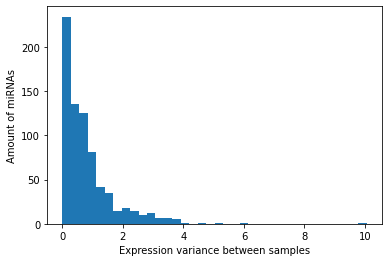

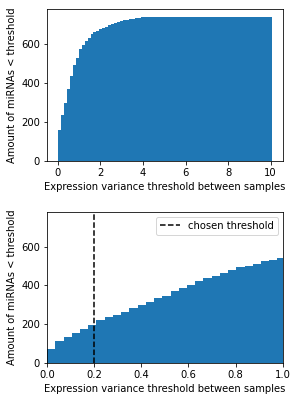

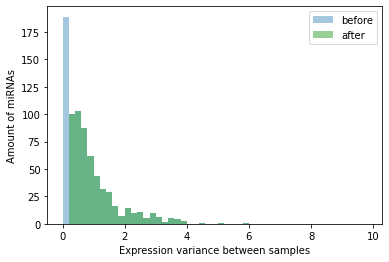

In [3]:
#download GDC ChGR37 miRNA expression data from XENA
def download_miRNA_data(tcga_path):
    if not tcga_path.exists():
        !mkdir $tcga_path
    if not Path(path/'tcga_miRNA').is_file():
        print(f'Download miRNA expression data from TCGA')
        !wget 'https://pancanatlas.xenahubs.net/download/pancanMiRs_EBadjOnProtocolPlatformWithoutRepsWithUnCorrectMiRs_08_04_16.xena.gz'
        !gunzip pancanMiRs_EBadjOnProtocolPlatformWithoutRepsWithUnCorrectMiRs_08_04_16.xena.gz
        !mv pancanMiRs_EBadjOnProtocolPlatformWithoutRepsWithUnCorrectMiRs_08_04_16.xena $path/tcga_miRNA

#variance filter, drop mirna counts that show no variance (not on gene level but on all caseids)
def filter_no_variance(mirna_counts,used_caseids,threshold=0.2):
    print(f'filter out mirnas with variance <= {threshold}\n  Number mirnas before: {len(mirna_counts)}') 
    here_caseids = list(used_caseids).copy()
    here_caseids.extend(['sample'])
    mirna_level = mirna_counts[here_caseids]
    mirna_level = mirna_level.assign(all_counts=mirna_level[used_caseids].apply(lambda column : [item for item in column if not pd.isna(item)],axis=1)).drop(used_caseids, 1)
    mirna_level['var'] = mirna_level['all_counts'].apply(lambda list_val : np.var(list_val,axis=0))
    before = mirna_level['var'].copy()
    fig1, ax1 = plt.subplots(figsize=(6,4))
    mirna_level['var'].plot(kind='hist', bins=36,ax=ax1)
    plt.ylabel("Amount of miRNAs") 
    plt.xlabel("Expression variance between samples")
    plt.savefig(tcga_path/'plots'/'mirna_var_filter.png', bbox_inches = "tight",dpi=200)
    fig1, axs = plt.subplots(2,1,figsize=(4,5.5))
    fig1.tight_layout(h_pad=3)
    mirna_level['var'].plot(kind='hist', bins=72, cumulative=True,ax=axs[0])
    axs[0].set_ylabel("Amount of miRNAs < threshold")
    axs[0].set_xlabel("Expression variance threshold between samples")
    mirna_level['var'].plot(kind='hist', bins=288, cumulative=True,ax=axs[1],label='')
    axs[1].set_xlim([0,1])
    axs[1].set_ylabel("Amount of miRNAs < threshold")
    axs[1].set_xlabel("Expression variance threshold between samples")
    plt.axvline(x = threshold, color = 'black', linestyle="--",label='chosen threshold') 
    plt.legend()
    plt.savefig(tcga_path/'plots'/'mirna_var_filter_thresh.png', bbox_inches = "tight",dpi=200)
    mirna_level['keep_mirna'] = mirna_level['var'] > threshold
    mirna_counts = mirna_counts.merge(mirna_level[['sample','keep_mirna']], how='inner', left_on='sample', right_on='sample')
    mirna_counts = mirna_counts[mirna_counts.keep_mirna].drop('keep_mirna',axis=1)
    mirna_level = mirna_level[mirna_level['keep_mirna']]
    fig1, ax1 = plt.subplots(figsize=(6,4))
    before.plot(kind='hist', bins=np.arange(0,int(max(before)),0.2),ax=ax1, alpha=0.4, color='tab:blue',label='before')
    mirna_level['var'].plot(kind='hist', bins=np.arange(0,int(max(before)),0.2),ax=ax1, alpha=0.5, color='tab:green',label='after')
    plt.ylabel("Amount of miRNAs")
    plt.xlabel("Expression variance between samples")
    plt.legend()
    plt.savefig(tcga_path/'plots'/'mirna_var_filter2.png', bbox_inches = "tight",dpi=200)
    print(f'  Number mirnas after: {len(mirna_counts)}')
    return mirna_counts

file = Path(tcga_path/'miRNA_counts.pickle')
if file.is_file():
    mirna_counts = pd.read_pickle(file)
else:
    download_miRNA_data(tcga_path)
    mirna_counts = pd.read_csv(path/'tcga_miRNA', delimiter='	')
    transcript_counts = get_expression_data(tcga_path, path, disease)
    used_caseids = list(transcript_counts.columns & mirna_counts.columns)
    used_caseids.remove('sample')
    nr_caseids = len(used_caseids)
    print(f'Exon and miRNA counts have {nr_caseids} common patient ids.')
    mirna_caseids = used_caseids.copy()
    mirna_caseids.extend(['sample'])
    mirna_counts = mirna_counts[mirna_caseids]
    mirna_counts = filter_no_variance(mirna_counts,used_caseids)
    mirna_counts.to_pickle(file)
mirna_counts

### miRNA level Elastic Net Regression

In [ ]:
#regression btw miRNA expression, exon expression

#split data into train and test subsets with trainsplit between 0 and 1
def split_train_test(data, train_split=0.8):
    train_split = int(train_split * len(data))
    train = data[:train_split]
    test = data[train_split:]
    return train, test

def run_elastic_net_regression(mirna_counts,exon_counts):
    models = {}
    data_info = {}
    train_data = {}
    test_data = {}
    for mirna in mirna_counts['sample']:
        y_info = mirna_counts[mirna_counts['sample'] == mirna].melt(id_vars=['sample'], var_name="case_id", value_name="mirna_count").dropna()
        X_info = y_info.merge(exon_counts,on='case_id',how='left').drop('mirna_count',axis=1)
        y = y_info.mirna_count
        X = X_info.drop(['sample','case_id'],axis=1)
        X_train, X_test = split_train_test(X)
        y_train, y_test = split_train_test(y)
        regr = ElasticNet(random_state=0)
        regr.fit(X_train, y_train)
        y_pred = regr.predict(X_test)
        rms = mean_squared_error(y_test, y_pred, squared=False)
        models[mirna] = (rms, regr)
        data_info[mirna] = (X_info, y_info)
        train_data[mirna] = (X_train, y_train)
        test_data[mirna] = (X_test, y_test)
    with open((tcga_path/'models.pickle'),"wb") as file:
        pickle.dump(models,file, protocol=pickle.HIGHEST_PROTOCOL)
    with open((tcga_path/'data_info.pickle'),"wb") as file:
        pickle.dump(data_info,file, protocol=pickle.HIGHEST_PROTOCOL)
    with open((tcga_path/'train_data.pickle'),"wb") as file:
        pickle.dump(train_data,file, protocol=pickle.HIGHEST_PROTOCOL)
    with open((tcga_path/'test_data.pickle'),"wb") as file:
        pickle.dump(test_data,file, protocol=pickle.HIGHEST_PROTOCOL)
    exon_ids = list(list(data_info.values())[0][0].columns) #list of exon IDs
    exon_ids.remove('sample')
    exon_ids.remove('case_id')
    with open((tcga_path/'exon_ids.pickle'),"wb") as file:
        pickle.dump(exon_ids,file, protocol=pickle.HIGHEST_PROTOCOL)
    print('Trained models were saved to disk.')
    return models, data_info, train_data, test_data
models, data_info, train_data, test_data = run_elastic_net_regression(mirna_counts,exon_counts)

/nfs/home/users/l.hackl/.conda/envs/thesis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13354761437597062, tolerance: 0.09931322605326878
  model = cd_fast.enet_coordinate_descent(
/nfs/home/users/l.hackl/.conda/envs/thesis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.19816346213806924, tolerance: 0.11551619031476999
  model = cd_fast.enet_coordinate_descent(


filter out models if RMSE >= 0.5
  Number models before: 554
  Number models after: 70
filter genes with no negative coefficients
  Number mirna-exon-bindingsites before: 39881870
  Number mirna-exon-bindingsites after: 21445


,sample,exon_id,coefficient,transcript_id,gene_id
1826,hsa-miR-1269a,ENSE00000341112.1,-0.0,"[ENST00000558330.5, ENST00000558259.5, ENST000...",ENSG00000034053.14
16326,hsa-miR-192-3p,ENSE00000434664.1,0.0,"[ENST00000359028.6, ENST00000394534.6, ENST000...",ENSG00000127914.16
16396,hsa-miR-192-3p,ENSE00000434665.1,0.0,"[ENST00000359028.6, ENST00000394534.6, ENST000...",ENSG00000127914.16
22776,hsa-miR-331-5p,ENSE00000460813.1,0.0,"[ENST00000265748.6, ENST00000396068.6, ENST000...",ENSG00000011426.10
22846,hsa-miR-331-5p,ENSE00000460818.1,0.0,"[ENST00000265748.6, ENST00000457743.1, ENST000...",ENSG00000011426.10


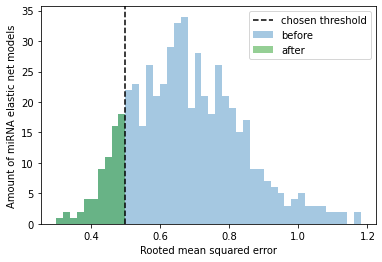

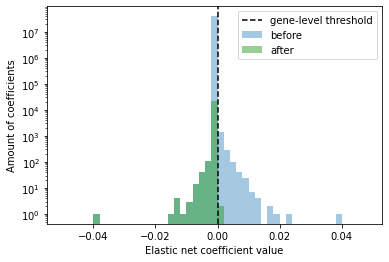

In [4]:
#filter mirna models by RMSE score
def filter_models_by_rmse(models, threshold=0.5):
    #plot histogram of rooted mean squared error score
    print(f'filter out models if RMSE >= {threshold}\n  Number models before: {len(models)}')
    before = [rmse_score for (rmse_score, model) in models.values()],
    models = {mirna:values for mirna, values in models.items() if values[0] < threshold} 
    print(f'  Number models after: {len(models)}')
    fig1, ax1 = plt.subplots(figsize=(6,4))
    plt.hist(before, bins=np.arange(0.3,1.2,0.02), alpha=0.4, color='tab:blue',label='before')
    plt.hist([rmse_score for (rmse_score, model) in models.values()], bins=np.arange(0.3,1.2,0.02), alpha=0.5, color='tab:green',label='after')
    plt.ylabel("Amount of miRNA elastic net models")
    plt.xlabel("Rooted mean squared error")
    plt.axvline(x = threshold, color = 'black', linestyle="--",label='chosen threshold') 
    plt.legend()
    plt.savefig(tcga_path/'plots'/'rmse_filter.png', bbox_inches = "tight",dpi=200)
    return models

#per miRNA model: if gene no negative coefficients: drop
def filter_coefficients_per_gene(coefficients, models, tcga_path):
    with open((tcga_path/'exon_ids.pickle'),'rb') as handle:
        exon_ids = pickle.load(handle) #read in exon ids for column
    #1 row per mirna, 1 column by exon, values = coefficients
    coefficients = pd.DataFrame(coefficients,index=models.keys(),columns=exon_ids)
    #1 row per mirna-exon
    coefficients.index.names = ['sample']
    coefficients = coefficients.reset_index()
    coefficients = coefficients.melt(id_vars=['sample'], var_name="exon_id", value_name="coefficient")
    # add gene_id
    exon2gene = pd.read_parquet(tcga_path/'exon2gene.parquet')
    coefficients = coefficients.merge(exon2gene)
    gene_coeff = coefficients.copy()
    gene_coeff = gene_coeff.groupby(['sample','gene_id'], as_index=False).agg({'coefficient':(lambda x: min(x)<0)}).rename({'coefficient':'keep_gene'},axis=1)
    nr_filtered_genes = len(gene_coeff[~gene_coeff.keep_gene].drop_duplicates(subset=['gene_id']))
    coefficients = coefficients.merge(gene_coeff[['sample','gene_id','keep_gene']], how='left')
    print(f'filter genes with no negative coefficients\n  Number mirna-exon-bindingsites before: {len(coefficients)}')
    before = coefficients.coefficient.values
    coefficients = coefficients[coefficients.keep_gene].drop(['keep_gene'],axis=1)
    print(f'  Number mirna-exon-bindingsites after: {len(coefficients)}')
    fig1, ax1 = plt.subplots(figsize=(6,4))
    plt.hist(before, bins=np.arange(-0.05,0.05,0.002), alpha=0.4, color='tab:blue',label='before')
    plt.hist(coefficients.coefficient.values, bins=np.arange(-0.05,0.05,0.002), alpha=0.5, color='tab:green',label='after')
    plt.ylabel("Amount of coefficients")
    plt.yscale("log")
    plt.xlabel("Elastic net coefficient value")
    plt.axvline(x = 0, color = 'black', linestyle="--",label='gene-level threshold') 
    plt.legend()
    plt.savefig(tcga_path/'plots'/'coeff_filter.png', bbox_inches = "tight",dpi=200)
    return coefficients
    
with open((tcga_path/'models.pickle'), 'rb') as handle:
    models = pickle.load(handle)
models = filter_models_by_rmse(models)
coefficients = [model.coef_ for (rmse_score, model) in models.values()]
coefficients = filter_coefficients_per_gene(coefficients, models, tcga_path)
coefficients.to_parquet(tcga_path/'bs_counts_filtered_gene.parquet')
coefficients.head()